# Import

In [1]:
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import re
import contractions
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import collections
import math
import pickle


import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
STOPWORDS = set(stopwords.words("english"))

import torchtext
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, random_split 
from torch import nn
import torch 

from tqdm import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print('device = ', DEVICE)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nguye\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


device =  cuda


# Hyperparams

In [2]:
root = os.getcwd()
dataset =  os.path.join(root, 'dataset', 'amazon_full')
#yelp polarity has 2 labels, 
#yelp dataset has 5 labels, they have the same text content
train_datapath = os.path.join(dataset, 'train.csv') 
test_datapath = os.path.join(dataset, 'test.csv') 

processed_train_dataset = os.path.join(dataset, 'processed_train_datset.pickle')
processed_test_dataset = os.path.join(dataset, 'processed_test_dataset.pickle')
vocab_save_path = os.path.join(dataset, 'vocab.pickle')

model_save_root = os.path.join(root, 'output', 'transformer')

if os.path.exists(model_save_root) == False:
    os.makedirs(model_save_root)

assert os.path.exists(train_datapath),  f"train dataset path {train_datapath} not found"
assert os.path.exists(test_datapath),   f"test dataset path {test_datapath} not found"

BATCH_SIZE = 64

sample_size = 0.1

# Loading dataset

In [3]:
train_df = pd.read_csv(train_datapath, names = ["review","title", "text"])
train_df.drop('title', axis =1, inplace=True)
train_df = train_df.sample(frac = sample_size)
print(train_df.shape)
label_map = {
    1: 0,
    2: 1,
    3: 2,
    4: 3,
    5: 4,
}
train_df['review'] = train_df['review'].map(label_map)
train_df.reset_index(inplace=True, drop = True)
print(train_df['review'].unique())
print(train_df['review'].value_counts())
train_df.head()

(300000, 2)
[2 0 1 4 3]
review
4    60203
1    60091
0    60031
2    59916
3    59759
Name: count, dtype: int64


,review,text
0,2,Interesting but kind of nauseating. In my opin...
1,0,Don't get this video if you have done any form...
2,1,This is the third pair of Levis I bought from ...
3,2,After seeing the reviews here and elsewhere on...
4,0,This is an unbelievable disapointment. I thoug...


In [4]:
test_df = pd.read_csv(test_datapath, names = ["review",'title', "text"])
test_df.drop('title', axis =1, inplace=True)
test_df = test_df.sample(frac = sample_size)
label_map = {
    1: 0,
    2: 1,
    3: 2,
    4: 3,
    5: 4,
}
test_df['review'] = test_df['review'].map(label_map)
print(test_df.shape)
test_df.reset_index(inplace=True, drop = True)
print(test_df['review'].value_counts())
test_df.head()

(65000, 2)
review
4    13089
0    13053
2    13001
3    12936
1    12921
Name: count, dtype: int64


,review,text
0,4,Lady Be Good was a very funny and informative ...
1,4,Looking to be a very Memerable season. Might b...
2,4,Frankly I loved this book. I think this series...
3,2,This compost keeper does look fine on the coun...
4,3,"Overall, its a very good cd. It contains 16 so..."


# Cleaning

In [5]:
# Cleaning Text

def remove_urls(text):
    #if there's link in text, like www.something.com, https://www.something.com,
    # replace it with the <url> token
    pattern = re.compile(r'https?://\S+|www\.\S+')
    text = pattern.sub(' ', text)
    return text

def remove_digits(text):
    return re.sub("\d", ' ', text)

def remove_punctation(text):
    return re.sub(r'[^\w\s]',' ',text)

def expand_contraction(text):
    return contractions.fix(text)

def remove_stopwords(text):
    return ' '.join([word for word in text.split(' ') if word not in STOPWORDS])

def clean_text(text):
    '''
    extract feature and label from line and process the text
    @params:
        text: string, format: __label__2 some text.
    @return:
        feature: string
        label: int, 0: bad review, 1 good review
    '''
    #Each line has format: __label__2 some text.
    #The first part is label, the rest is text feature
    #lower case the features
    text = text.lower()
    #start cleaning

    #remove urls in text
    text = remove_urls(text)
    #remove digits
    text = remove_digits(text)
    # # #expand contractions
    text = expand_contraction(text)
    # # #remove punctuations
    text = remove_punctation(text)
    # # #remove stop words
    text = remove_stopwords(text)

    #after cleaning, there's a letter n that occur most frequently
    #this don't make sense so remove a standalone letter n
    text = ' '.join(t for t in text.split() if t != '' and t != 'n')
    return text.strip()

test_string = '''This is a test string. Here are some special characters: &,#,$. How about some punctuations? !@#$%^&*()_+=-`~{[]}|:;'<,>.?/"|https://www.example.com'''

clean_text(test_string)


'test string special characters punctuations _'

In [6]:
eda_df = train_df.copy()
eda_df['text'] = eda_df['text'].apply(lambda s: clean_text(s))
eda_df['lengths'] = eda_df['text'].apply(lambda s: len(s))
MAX_LENGTH = eda_df['lengths'].max()
print(MAX_LENGTH)
eda_df.head()

894


,review,text,lengths
0,2,interesting kind nauseating opinion book tries...,183
1,0,get video done form yoga previously video weir...,72
2,1,third pair levis bought amazon belt loop torn ...,198
3,2,seeing reviews elsewhere web thought get cats ...,295
4,0,unbelievable disapointment thought replacing y...,171


In [7]:
# Stats
eda_df.describe()


,review,lengths
count,300000.000000,300000.000000
mean,2.000040,253.987233
std,1.415142,149.672029
min,0.000000,0.000000
25%,1.000000,128.000000
50%,2.000000,223.000000
75%,3.000000,356.000000
max,4.000000,894.000000


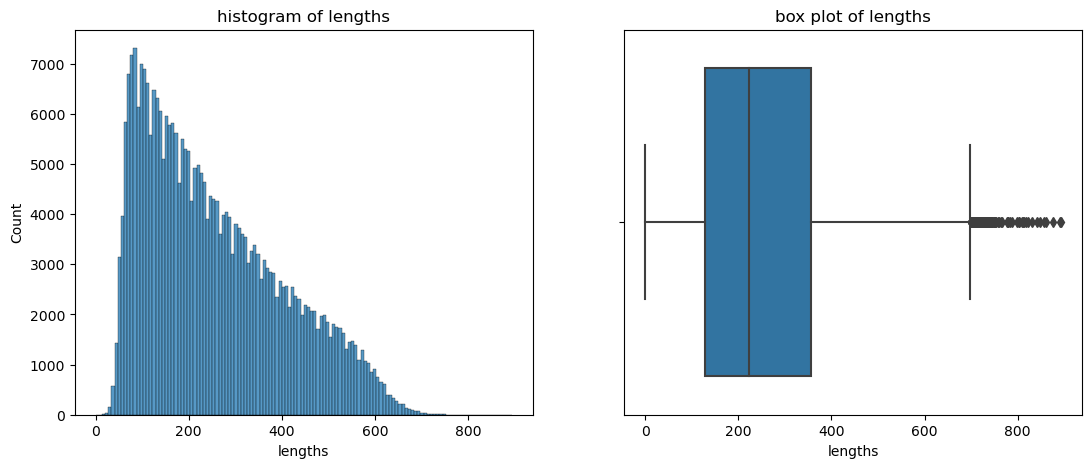

In [8]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(13,5))
sns.histplot(eda_df, x = 'lengths', ax = ax1)
ax1.set_title('histogram of lengths')
sns.boxplot(eda_df, x = 'lengths', ax = ax2)
ax2.set_title('box plot of lengths')
plt.show()

# A little EDA

In [9]:
# # wordcloud of common words
# freq = collections.Counter()

# for row in eda_df.iterrows():
#     label, text = row[1]
#     freq.update(text.split())

# print('most frequent words')
# print(freq.most_common(10))


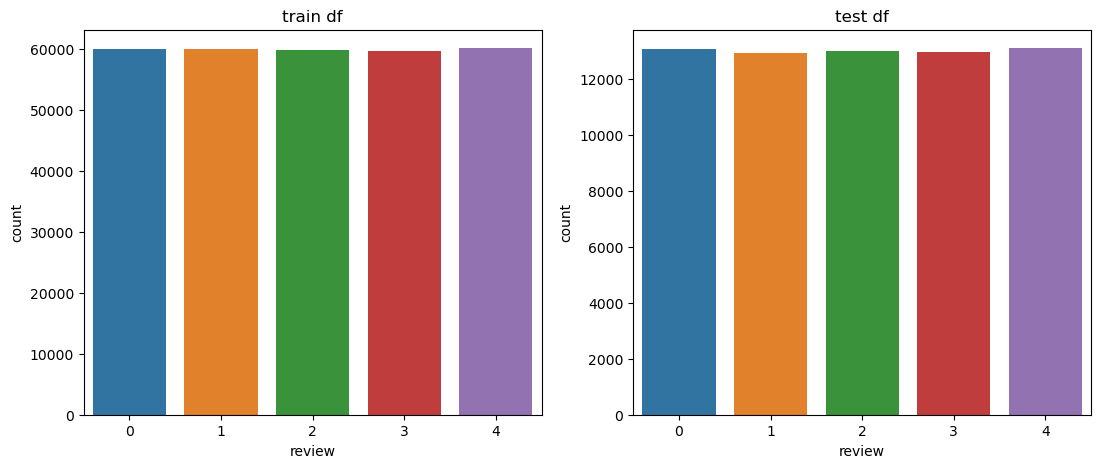

In [10]:
# bad_reviews = eda_df.loc[eda_df['review'] == 1]['text'].apply(lambda s: len(s)).values
# good_reviews = eda_df.loc[eda_df['review'] == 2]['text'].apply(lambda s: len(s)).values
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(13,5))
sns.countplot(train_df, x = 'review', ax = ax1)
ax1.set_title('train df')
sns.countplot(test_df, x = 'review', ax = ax2)
ax2.set_title('test df')
plt.show()

# Prepare data

In [11]:
tokenizer = torchtext.data.utils.get_tokenizer("basic_english")

def build_array(X, maxlength = 800):
    X_tokens = []
    X_lengths = []
    max_len = 0
    for text in tqdm(X):
        tokens = tokenizer(text)[:maxlength]
        max_len = max(max_len, len(tokens))
        X_tokens.append(tokens)
        X_lengths.append(len(tokens))

    print('max len = ', max_len)
    return X_tokens, X_lengths


def get_ids(tokens, vocab):
    ids = vocab.lookup_indices(tokens)
    return torch.tensor(ids)

def build_train_test_data(feature_train, label_train, min_vocab_freq = 2, **kwargs):
    train_tokens, train_lengths = build_array(feature_train)

    unk_token = '<unk>'
    pad_token = '<pad>'
    special_tokens = [unk_token, pad_token]

    vocab = torchtext.vocab.build_vocab_from_iterator(
        train_tokens,
        min_freq=min_vocab_freq,
        specials=special_tokens,
    )

    unk_id = vocab[unk_token]
    pad_id = vocab[unk_token]

    vocab.set_default_index(unk_id)

    print('vocab len = ', len(vocab))

    def convert_to_ids_labels_lengths(token_list, labels, lengths):
        id_list = []

        for tokens in tqdm(token_list):
            ids = get_ids(tokens, vocab)
            id_list.append(ids)

        #convert y to tensor
        labels = torch.tensor(labels)
        #convert X lengths to tensor
        lengths = torch.tensor(lengths)

        return id_list, labels, lengths

    train_ids, train_y, train_lengths = convert_to_ids_labels_lengths(train_tokens, label_train, train_lengths)

    return (train_tokens, train_ids, train_y, train_lengths), vocab, pad_id


In [12]:
all_df = pd.concat([train_df, test_df])
all_df['text'] = all_df['text'].apply(lambda s: clean_text(s))

912


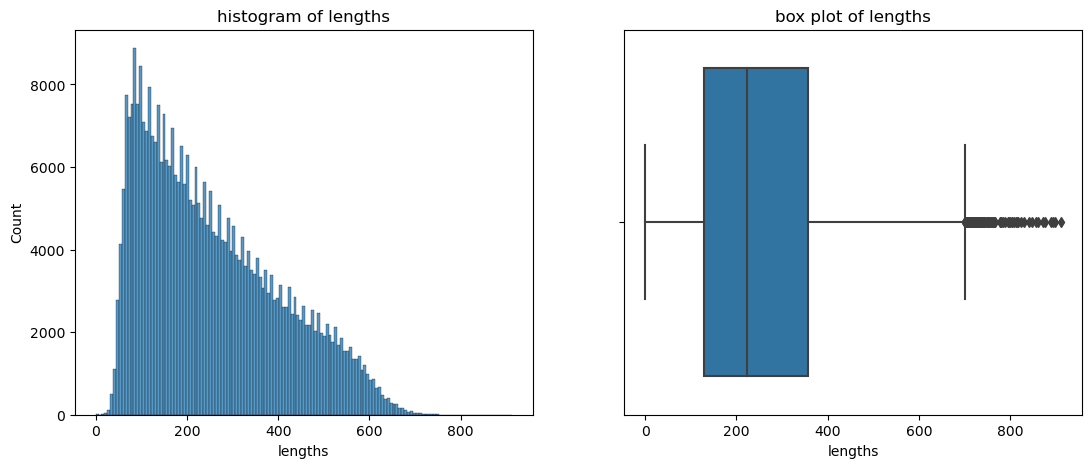

In [13]:
df = all_df.copy()
df['text'] = df['text'].apply(lambda s: clean_text(s))
df['lengths'] = df['text'].apply(lambda s: len(s))
MAX_LENGTH = df['lengths'].max()
print(MAX_LENGTH)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(13,5))
sns.histplot(df, x = 'lengths', ax = ax1)
ax1.set_title('histogram of lengths')
sns.boxplot(df, x = 'lengths', ax = ax2)
ax2.set_title('box plot of lengths')
plt.show()

In [14]:

X_array = all_df['text'].values
y_array = all_df['review'].values

(train_tokens, train_ids, train_y, train_lengths) ,vocab, pad_id = build_train_test_data(X_array, y_array)

train_ids = pad_sequence(train_ids, batch_first=True, padding_value=pad_id)

print('ids shape = ', train_ids.shape )
print('y values = ', set(train_y.tolist()) )
print('y shape = ', train_y.shape )
print('lengths shape = ', train_lengths.shape)

100%|██████████| 365000/365000 [00:08<00:00, 43116.62it/s]


max len =  167
vocab len =  103165


100%|██████████| 365000/365000 [00:07<00:00, 50218.36it/s]


ids shape =  torch.Size([365000, 167])
y values =  {0, 1, 2, 3, 4}
y shape =  torch.Size([365000])
lengths shape =  torch.Size([365000])


In [16]:
for label, token, id, length in zip(train_y[:1], train_tokens[:1], train_ids[:1], train_lengths[:1]):
    print(f'label={label}\ntokens={token}\nlength={length}\nids={id}')

print('vocab len = ', len(vocab))

label=2
tokens=['interesting', 'kind', 'nauseating', 'opinion', 'book', 'tries', 'glorify', 'porn', 'sleezy', 'industry', 'really', 'even', 'know', 'read', 'however', 'book', 'written', 'well', 'beleive', 'mr', 'jeremy', 'sold', 'self', 'ultimately', 'book', 'details', 'reasons']
length=27
ids=tensor([  109,   170, 12595,   454,     2,  1279, 16780,  4322, 25736,  1839,
           11,    16,    40,     9,    51,     2,   123,    12,  6649,   399,
         6850,  1124,   467,  1970,     2,   725,  1398,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
   

# Model

In [17]:
class PositionalEncoding(nn.Module):

    def __init__(self, num_hiddens: int, dropout:float = 0, max_len: int = 5000):
        super().__init__()
        assert num_hiddens % 2 == 0, f'num hiddens ({num_hiddens}),has to be even'

        self.dropout = nn.Dropout(dropout)

        self.P = torch.zeros((1, max_len, num_hiddens))
        x = torch.arange(max_len).float().unsqueeze(1)
        #N = 10000 as defined in the Attention is All You Need paper
        denom = torch.pow(10000, torch.arange(0, num_hiddens,2).float()/num_hiddens)
        x = x/denom
        self.P[:,:,0::2] = torch.sin(x)
        self.P[:,:,1::2] = torch.cos(x)

        # self.P = self.P.to(device)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # assert x.device == self.P.device, 'in positional encoding, X should have the same device with P'
        batch_size, length, num_hiddens = x.shape
        x = x + self.P[:,:length,:].to(x.device)
        return self.dropout(x)

class TransformerClassifier(nn.Module):
    def __init__(self, input_size, num_class, 
    num_heads, dim_fc, num_tokens, 
    dropout = 0.2, num_encoder_layers = 2, batch_first = True):

        '''
        @params:
            input_size: input features or embedding size
            num_heads: number of multi attentino heads 
            dim_fc:  dimension of feedforward layer
            dropout: drop out rate
            num_tokens: number of tokens in vocabulary (some call vocab_size)
        '''
        super().__init__()

        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(input_size, dropout)
        self.encoder_layers = nn.TransformerEncoderLayer(
            d_model = input_size,
            nhead = num_heads,
            dim_feedforward= dim_fc,
            dropout = dropout,
            batch_first=batch_first,
        )

        self.encoder = nn.TransformerEncoder(encoder_layer=self.encoder_layers, num_layers = num_encoder_layers)
        self.embedding = nn.Embedding(num_tokens, input_size)
        self.input_size = input_size 

        self.fc = nn.Linear(input_size, num_class) 

        self._init_weights()
    
    def _init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()
        self.fc.weight.data.uniform_(-initrange, initrange)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)
    
    def forward(self, src, mask = None):
        batch_size, input_len = src.shape
        
        src = self.embedding(src)
        src = src * math.sqrt(self.input_size)
        src = self.pos_encoder(src)

        if mask == None:
            mask = nn.Transformer.generate_square_subsequent_mask(input_len).to(src.device)

        transformer_output = self.encoder(src, mask)

        # print('transformer output shape = ', transformer_output.shape)
        output = self.fc(transformer_output[:,-1]) 
        # print('fc output shape = ', output.shape)
        return output

In [18]:
input_size = 100 
num_class = 2
num_heads = 5
fc_hidden_size = 5
num_tokens = 1000
    
clf = TransformerClassifier(input_size, num_class, num_heads, fc_hidden_size, num_tokens)
clf.to(DEVICE)
# clf.convert_to_device(DEVICE)
X = torch.randint(0,1000,(10,5)).to(DEVICE)

y = clf(X, None)

# Dataset

In [19]:
class YelpReview(Dataset):

    def __init__(self, ids, labels, lengths):
        self.ids = ids
        self.labels = labels
        self.lengths = lengths

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        return self.ids[idx], self.labels[idx], self.lengths[idx]


In [20]:
train_dataset = YelpReview(train_ids, train_y, train_lengths)
# test_dataset = YelpReview(test_ids, train_y, train_lengths)

print(train_dataset)

# Save the YelpDataset

with open(processed_train_dataset, 'wb') as file:
    pickle.dump(train_dataset, file)

# with open(processed_test_dataset, 'wb') as file:
#     pickle.dump(test_dataset, file)

with open(vocab_save_path, 'wb') as file:
    pickle.dump(vocab, file)


In [21]:
# Load dataset
with open(processed_train_dataset, 'rb') as file:
    train_dataset = pickle.load(file)

# with open(processed_test_dataset, 'rb') as file:
#     test_dataset = pickle.load(file)

with open(vocab_save_path, 'rb') as file:
    vocab = pickle.load(file)

print(train_dataset)
print(vocab)
print(len(vocab))

NUM_CLASSES = len(set(train_dataset.labels.tolist()))
print('num classes = ', NUM_CLASSES)

Vocab()
103165
num classes =  5


In [22]:
# test model running on dataloader

train_ratio = 0.8
train_len = int(train_ratio * len(train_dataset))
test_val_len = (len(train_dataset) - train_len)//2
train_dataset, val_dataset, test_dataset = random_split(train_dataset,[train_len, test_val_len, test_val_len])

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle = True)

print('num class = ', NUM_CLASSES)
print('train dataset len = ', len(train_dataset))
print('train dataloader len = ', len(train_dataloader))
print('val dataset len = ', len(val_dataset))
print('val dataloader len = ', len(val_dataloader))
print('test dataset len = ', len(test_dataset))
print('test dataloader len = ', len(test_dataloader))

(sample_ids, sample_y, sample_lengths) = next(iter(train_dataloader)) 
print('id shape = ', sample_ids.shape)
print('label shape = ', sample_y.shape)
print('lengths shape = ', sample_lengths.shape)


num class =  5
train dataset len =  292000
train dataloader len =  2282
val dataset len =  36500
val dataloader len =  286
test dataset len =  36500
test dataloader len =  286
id shape =  torch.Size([128, 167])
label shape =  torch.Size([128])
lengths shape =  torch.Size([128])


# Tune function

In [23]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

def train(dataloader, model, criterion, optimizer, device):
    model.to(device)
    model.train()
    epoch_losses = []
    epoch_accs = []

    for ids, label, length in tqdm(dataloader, desc="training..."):
        ids = ids.to(device)
        label = label.to(device)
        length = length
        # prediction = model(ids, length)
        prediction = model(ids)

        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

def pickle_dump(obj, path):
    with open(path, 'wb') as file:
        pickle.dump(obj, file)
        
def pickle_load(path):
    with open(path, 'wb') as file:
        obj = pickle.load(file)
    return obj

def evaluate(dataloader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    
    for ids, label, length in tqdm(dataloader, desc="evaluating..."):
        ids = ids.to(device)
        length = length
        label = label.to(device)
        # prediction = model(ids, length)
        prediction = model(ids)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
            
    return np.mean(epoch_losses), np.mean(epoch_accs)

def tune(model,train_dataloader, val_dataloader, test_dataloader,  
         optimizer, criterion, device, epochs = 10, label = 'baseline', history = None):
    print(f"The model has {model.count_parameters()} trainable parameters")

    criterion = criterion.to(device)
    best_score = -float("inf")

    save_path = os.path.join(model_save_root, label)
    if os.path.exists(save_path) == False:
        os.makedirs(save_path)

    if history == None:
        history = collections.defaultdict(list)

    for epoch in range(epochs):
        train_loss, train_acc = train(train_dataloader, model, criterion, optimizer, device)
        val_loss, val_acc = evaluate(val_dataloader, model, criterion, device)
        test_loss, test_acc = evaluate(test_dataloader, model, criterion, device)
        history["train_losses"].append(train_loss)
        history["train_accs"].append(train_acc)
        history["valid_losses"].append(val_loss)
        history["valid_accs"].append(val_acc)
        history["test_losses"].append(test_loss)
        history["test_accs"].append(test_acc)

        print(f"epoch: {epoch}")
        print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
        print(f"val_loss: {val_loss:.3f}, valid_acc: {val_acc:.3f}")
        print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")
        pickle_dump(history, os.path.join(save_path, 'history.pickle'))
        torch.save(model, os.path.join(save_path, f"yelp.transformers.checkpoint.pt"))

        plot(history, save_path = os.path.join(save_path, 'plot.png'))

    if test_acc < best_score:
        best_score = test_loss
        torch.save(model, os.path.join(model_save_root, f"yelp.transformers.best.pt"))
    
    plot(history, save_path = os.path.join(save_path, 'plot.png'), show = True)
    return history

def plot(history, save_path = None, show = False):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
    epochs = list(range(len(history['train_accs'])))
    sns.lineplot(y = history["train_accs"],   label ='train accuracy',  x = epochs, ax = ax1)
    sns.lineplot(y = history["valid_accs"],   label ='val accuracy',    x = epochs, ax = ax1)
    sns.lineplot(y = history["test_accs"],   label ='test accuracy',    x = epochs, ax = ax1)
    ax1.set_title("Accuracy")

    sns.lineplot(y = history["train_losses"], label ='train loss', x = epochs, ax = ax2)
    sns.lineplot(y = history["valid_losses"],   label ='val loss', x = epochs, ax = ax2)
    sns.lineplot(y = history["test_losses"],   label ='test loss', x = epochs, ax = ax2)
    ax2.set_title("Loss")

    if save_path:
        plt.savefig(save_path)
    if show:
        plt.show()
    plt.clf()

# Pretrained embedding

In [24]:
vectors = torchtext.vocab.GloVe()
pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())

# Run transformers

### Dropout Rate

In [25]:
lr = 5e-4
vocab_size = len(vocab)
embedding_dim = 300
hidden_dim = 300
output_dim = NUM_CLASSES
print('output dim = ', output_dim)
n_layers = 2
bidirectional = True
dropout_rate = 0.5

model = TransformerClassifier(
    input_size = embedding_dim,
    num_class=  NUM_CLASSES,
    num_heads = 5,
    dim_fc = 128,
    num_tokens = vocab_size,
    dropout = dropout_rate
)

model.embedding.weight.data = pretrained_embedding

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

history = tune(model,  train_dataloader, val_dataloader, test_dataloader, 
               optimizer, criterion, epochs = 10, device = DEVICE)

plot(history)

output dim =  5
The model has 32269889 trainable parameters


evaluating...: 100%|██████████| 286/286 [00:05<00:00, 48.77it/s]


epoch: 0
train_loss: 1.315, train_acc: 0.423
val_loss: 1.578, valid_acc: 0.472
test_loss: 1.572, test_acc: 0.471


evaluating...: 100%|██████████| 286/286 [00:05<00:00, 48.75it/s]


epoch: 1
train_loss: 1.221, train_acc: 0.468
val_loss: 1.560, valid_acc: 0.475
test_loss: 1.550, test_acc: 0.476


evaluating...: 100%|██████████| 286/286 [00:05<00:00, 48.71it/s]


epoch: 2
train_loss: 1.191, train_acc: 0.484
val_loss: 1.481, valid_acc: 0.482
test_loss: 1.462, test_acc: 0.482


evaluating...: 100%|██████████| 286/286 [00:05<00:00, 49.45it/s]


epoch: 3
train_loss: 1.168, train_acc: 0.497
val_loss: 1.505, valid_acc: 0.484
test_loss: 1.493, test_acc: 0.483


evaluating...: 100%|██████████| 286/286 [00:05<00:00, 48.89it/s]


epoch: 4
train_loss: 1.147, train_acc: 0.508
val_loss: 1.451, valid_acc: 0.484
test_loss: 1.435, test_acc: 0.482


evaluating...: 100%|██████████| 286/286 [00:05<00:00, 49.78it/s]


epoch: 5
train_loss: 1.127, train_acc: 0.518
val_loss: 1.511, valid_acc: 0.485
test_loss: 1.499, test_acc: 0.482


evaluating...: 100%|██████████| 286/286 [00:05<00:00, 49.57it/s]


epoch: 6
train_loss: 1.109, train_acc: 0.527
val_loss: 1.571, valid_acc: 0.481
test_loss: 1.559, test_acc: 0.479


evaluating...: 100%|██████████| 286/286 [00:05<00:00, 48.73it/s]


epoch: 7
train_loss: 1.092, train_acc: 0.537
val_loss: 1.575, valid_acc: 0.487
test_loss: 1.569, test_acc: 0.483


evaluating...: 100%|██████████| 286/286 [00:05<00:00, 48.69it/s]


epoch: 8
train_loss: 1.076, train_acc: 0.547
val_loss: 1.715, valid_acc: 0.479
test_loss: 1.705, test_acc: 0.476


training...:  82%|████████▏ | 1872/2282 [02:10<00:29, 13.91it/s]

# Notes

test accuracy not improving. Perhaps the train vocab and test vocab is too different. Try merging train and test tokens. See what happens.